# Algorithms for Table 1

This Jypyter Notebook takes the first table, and produces an optimal machine learning algorithm on it. That is, it takes patients' initial movement variables, including their angle of shoulder abduction, shoulder flexion, and elbow flextion, and outputs whether the patient should be playing a game of Easy, Medium, or Hard difficulty.

First, we import the necessary packages, load them into a pandas DataFrame, and display a sample of the data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings(action = 'ignore')
# ignoring warnings, to make the results simpler to read

In [3]:
new = pd.read_excel('Data1.xlsx', sheet_name = 'Table1 - Assessments')

In [4]:
new.set_index('Patient No. (ID)', inplace=True)

In [5]:
new.sample(10)

,Average Shoulder abduction,Average Shoulder flexion,Average Elbow flexion,Total time taken,Output
Patient No. (ID),,,,,
30,78,68,78,107,Medium
47,111,84,87,97,Medium
70,139,106,100,86,Hard
66,135,102,97,89,Hard
42,102,76,84,101,Medium
58,125,96,95,92,Hard
49,116,88,89,96,Medium
10,54,51,54,124,Easy
29,76,67,78,108,Medium


This is how the data looks. It contains labelled data for 75 different patients, but here we are taking a random sample of 10. The output: Easy, Medium, and Hard, indiciates the label of each patient. This is what we want the machine algorithm to predict. Next we plot the data visually. We start with a pairplot, in order to visualise the correlation between Average Shoulder abduction, Average Shoulder flexion, Average Eblow flexion, and Total time taken.

## Data Visualisation

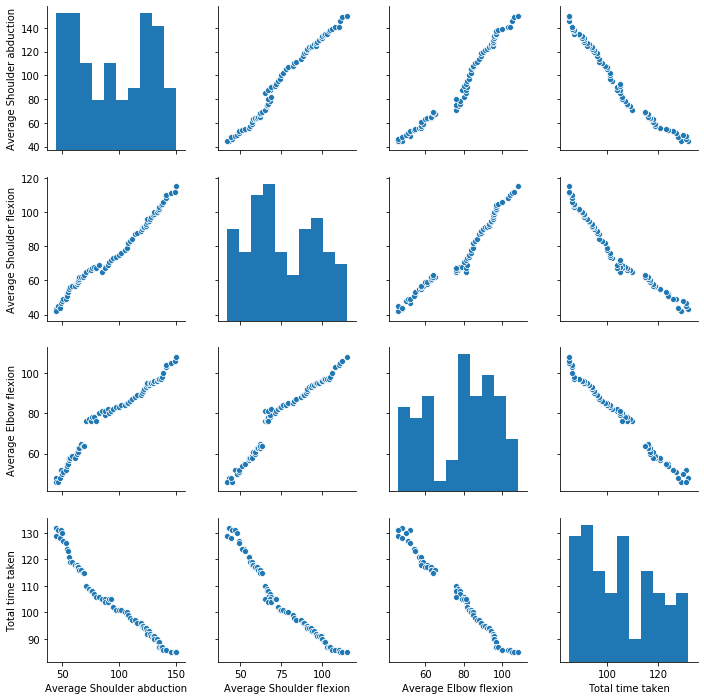

In [6]:
sns.pairplot(new[['Average Shoulder abduction', 'Average Shoulder flexion', 'Average Elbow flexion', 'Total time taken']])

As we can see, there is a strong positive correlation between Average Shouolder Abduction, Average Shoulder flexion, and Average elbow flexion. Each of these, moreover, are strongly negatively correlated with total time taken. That is, the greater the range of movement in one indicator, the greater the range of movements in the other, and less time it takes the patient to perform these movements. Next, we look at the distributions of each of these input features:

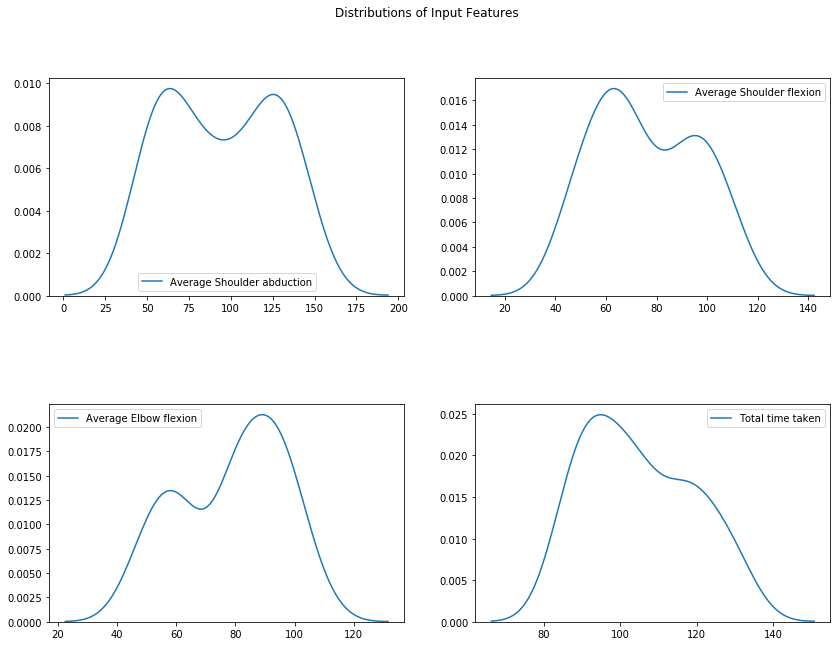

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
fig.subplots_adjust(hspace=0.5)
fig.suptitle('Distributions of Input Features')
sns.kdeplot(new['Average Shoulder abduction'], ax=axes[0][0])
sns.kdeplot(new['Average Shoulder flexion'], ax=axes[0][1])
sns.kdeplot(new['Average Elbow flexion'], ax=axes[1][0])
sns.kdeplot(new['Total time taken'], ax=axes[1][1])

As we can see here, each of the four input variables have similar means, variances and ranges, even though the mode differs for each. This will tend to mean that patients classified into Medium will have a small range of values for each of the input varaibles, whereas patients classified into Easy and Hard will have greater ranges, for at the tails, the spread of data is greater. We next plot violin plots of the different input variables across the difficulty levels (Output), to see how they differ across the labels. Note that a violin plot is very similar to a box plot, except a violin also (in addition showing the median, quartiles, and ranges) shows the probabilitity density of the data, and therefore its full distribution. Violin plots are therefore more informative than box plots.

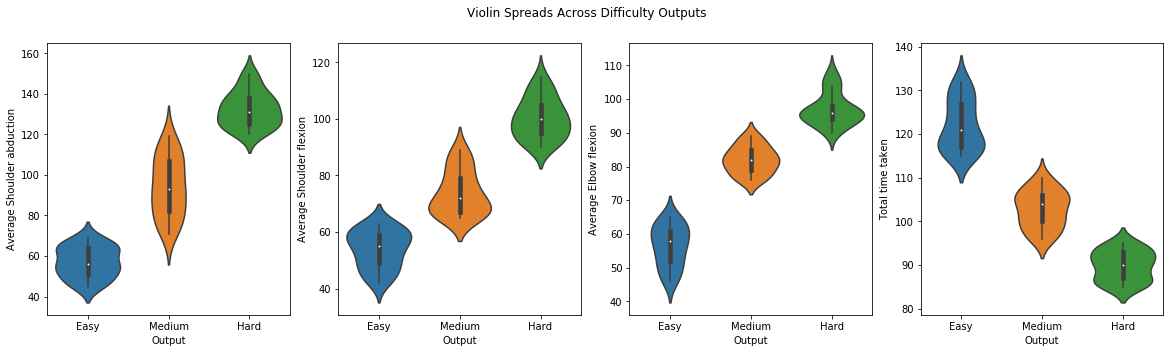

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.subplots_adjust(hspace=0.5)
fig.suptitle('Violin Spreads Across Difficulty Outputs')
columns = ['Average Shoulder abduction', 'Average Shoulder flexion', 'Average Elbow flexion', 'Total time taken']
for i, p in enumerate(columns):
    sns.violinplot(
        x='Output',
        y=p,
        data=new,
        ax=axes[i]
    )

From this, it can be cearly seen that the data are distinguishable across output classes. This will make the modelling task more simplistic, allowing the models to separete the classes with little overlap.

## Data Preprocessing

Next, we preprocess the data. But before this, we need to split it. We allocate 80% of the data to training (60 patients) and 20% to testing (15 patients). We also separate the output from the inputs.

In [9]:
from sklearn.model_selection import train_test_split
X = new.drop(columns=['Output'])
y = new.Output
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

In [10]:
X_train.sample(5)

,Average Shoulder abduction,Average Shoulder flexion,Average Elbow flexion,Total time taken
Patient No. (ID),,,,
40,97,74,83,101
54,124,92,93,94
3,46,45,46,131
42,102,76,84,101
41,100,75,83,101


In [11]:
y_train.sample(5)

Patient No. (ID)
74      Hard
67      Hard
75      Hard
34    Medium
40    Medium
Name: Output, dtype: object

To begin the preprocessing, we label encode the data. For this, we could useLabelEncoder from the Scikit Learn library. However, Label Encoder converts each category into a random number, and such a process loses the ordability of the output variable. To solve this issue, we will label encode the output column manually.

In [12]:
def label_encoder(y):
    if y == 'Easy':
        return 1
    if y == 'Medium':
        return 2
    if y == 'Hard':
        return 3
y_train = y_train.apply(label_encoder)
y_test = y_test.apply(label_encoder)

In [13]:
y_train.sample(3)

Patient No. (ID)
29    2
5     1
59    3
Name: Output, dtype: int64

Next, the data is scaled. This is done in order to ensure that data with different units are consistent across the table. The process centres the data with mean of 0, and standard deviation of 1.

In [14]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train) 
X_test_scaled = scaler.transform(X_test)

In [15]:
X_train_scaled

array([[ 0.22149097, -0.00244184,  0.31347326, -0.27358972],
       [ 1.01398157,  1.02313166,  0.93664299, -0.97811261],
       [-0.3881172 , -0.34429967,  0.08686608,  0.07867172],
       [ 1.1054228 ,  1.16964216,  0.99329478, -1.0485649 ],
       [ 0.31293219,  0.09523182,  0.31347326, -0.34404201],
       [ 1.34926606,  1.46266316,  1.21990196, -1.33037405],
       [ 1.41022688,  1.56033682,  1.38985734, -1.33037405],
       [ 0.06908892, -0.10011551,  0.25682146, -0.27358972],
       [-0.93676454, -0.78383117, -0.87621441,  0.8536469 ],
       [-0.90628413, -0.68615751, -0.87621441,  0.78319461],
       [-0.57099964, -0.44197334, -0.0264375 ,  0.2195763 ],
       [ 1.22734443,  1.26731582,  1.04994658, -1.11901719],
       [ 0.92254035,  0.87662116,  0.8799912 , -0.83720803],
       [ 1.1054228 ,  1.12080532,  0.99329478, -0.97811261],
       [-1.51589229, -1.66289417, -1.8392949 ,  1.69907436],
       [ 0.00812811, -0.14895234,  0.20016967, -0.20313743],
       [ 0.98350117,  0.

## Classification

Now the running of Machine Learning algorithms can begin. This notebook starts by training classification-based algorithms on the training data. We also use Grid Search hyperparamter optimisation to choose the hyperparamters that maximise the accuracy scores of the models. Accuracy scoring is on a range between 0 and 1, where 0 indicates worst performance, and 1 best. We train eight classification models here, and run each one seveal times, with different combinations of hyperparameter values. We output the classification scores for each: for each model with their optimal hyperparamters. We then choose the model that maximises classification scores.

In [16]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

In [17]:
parameters_RFC = {'n_estimators': [4, 6, 9], 
                  'max_features': ['log2', 'sqrt','auto'], 
                  'criterion': ['entropy', 'gini'],
                  'max_depth': [2, 3, 5, 10], 
                  'min_samples_split': [2, 3, 5],
                  'min_samples_leaf': [1,5,8]
                 }
parameters_XGBC = {'n_estimators': [400, 600, 800], 
                  'early_stopping_rounds': [3, 5, 7], 
                  'learning_rate': [0.05, 0.1, 0.3, 0.5]
                  } 
parameters_SVM = {'C' : [0.01, 0.1, 1, 10, 100],
                 'kernel': ['linear', 'rbf', 'sigmoid'],
                  'gamma': [0.001, 0.01, 0.1, 1]
                 }
parameters_decision_tree = {'criterion': ['entropy', 'gini'],
                             'max_depth': [2, 3, 5, 10],
                            'min_samples_split': [2, 3, 5],
                              'min_samples_leaf': [1,5,8]
                           }
parameters_NB = {'priors' : [None]}
parameters_kNN = {'n_neighbors': [3, 5, 10, 15],
                 'p': [1, 2, 3, 4]}
parameters_LDA = {'solver': ['svd', 'lsqr', 'eigen']}
parameters_logistic = {'C': np.logspace(-3, 3, 7),
                      'penalty': ['l1', 'l2']}

models = {'SVM': [SVC(), parameters_SVM],
          'Logistic': [LogisticRegression(), parameters_logistic],
          'LDA': [LinearDiscriminantAnalysis(), parameters_LDA],
          'kNN': [KNeighborsClassifier(), parameters_kNN],
          'Decision Tree': [DecisionTreeClassifier(), parameters_decision_tree],
          'Naive Bayes' : [GaussianNB(), parameters_NB],
        'Random Forest': [RandomForestClassifier(), parameters_RFC],
         'XGBoost': [XGBClassifier(), parameters_XGBC]}

In [18]:
def best_classifier(models):
    global results
    results = {}
    for i in models:
        CV = GridSearchCV(models[i][0], models[i][1], cv=5, iid=False, scoring='accuracy', n_jobs=1)
        CV = CV.fit(X_train_scaled, y_train)
        print(f'{i} scored {CV.best_score_}')
        results[i] = [CV.best_score_, CV.best_estimator_]
    return results

In [19]:
best_classifier(models)

SVM scored 0.9818181818181818
Logistic scored 0.9818181818181818
LDA scored 0.9469696969696969
kNN scored 0.9636363636363636
Decision Tree scored 1.0
Naive Bayes scored 0.9636363636363636
Random Forest scored 1.0
XGBoost scored 0.9484848484848485


{'SVM': [0.9818181818181818,
  SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
      decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
      probability=False, random_state=None, shrinking=True, tol=0.001,
      verbose=False)],
 'Logistic': [0.9818181818181818,
  LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
                     intercept_scaling=1, l1_ratio=None, max_iter=100,
                     multi_class='warn', n_jobs=None, penalty='l1',
                     random_state=None, solver='warn', tol=0.0001, verbose=0,
                     warm_start=False)],
 'LDA': [0.9469696969696969,
  LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                             solver='svd', store_covariance=False, tol=0.0001)],
 'kNN': [0.9636363636363636,
  KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                       metric_params=None, n_jobs=None, n_neighbors=3, p

The first eight lines in the above output show the accuracy scores for each model, with optimal hyperparamters (obtained from a given range using Grid Search hypereparameter optimisation). Decision Trees and Random Forests both achieve 100% accuracy scores. Before we select a model, however, we try running the same algorithms and Grid Search hyperparameter optimisation technique without data standardisation using StandardScalar(). If we get the same accuracy scores without data scaling, the decision tree will become more interpretable, as it will deal with initial input values into the algorithm.

In [20]:
def best_classifier(models):
    global results
    results = {}
    for i in models:
        CV = GridSearchCV(models[i][0], models[i][1], cv=5, iid=False, scoring='accuracy', n_jobs=1)
        CV = CV.fit(X_train, y_train)
        print(f'{i} scored {CV.best_score_}')
        results[i] = [CV.best_score_, CV.best_estimator_]
    return results

In [21]:
best_classifier(models)

SVM scored 0.9818181818181818
Logistic scored 0.9818181818181818
LDA scored 0.9469696969696969
kNN scored 0.9636363636363636
Decision Tree scored 1.0
Naive Bayes scored 0.9636363636363636
Random Forest scored 1.0
XGBoost scored 0.9484848484848485


{'SVM': [0.9818181818181818,
  SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
      decision_function_shape='ovr', degree=3, gamma=0.001, kernel='linear',
      max_iter=-1, probability=False, random_state=None, shrinking=True,
      tol=0.001, verbose=False)],
 'Logistic': [0.9818181818181818,
  LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
                     intercept_scaling=1, l1_ratio=None, max_iter=100,
                     multi_class='warn', n_jobs=None, penalty='l1',
                     random_state=None, solver='warn', tol=0.0001, verbose=0,
                     warm_start=False)],
 'LDA': [0.9469696969696969,
  LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                             solver='svd', store_covariance=False, tol=0.0001)],
 'kNN': [0.9636363636363636,
  KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                       metric_params=None, n_jobs=None, n_neighbo

As we can see from above, the accuracy scores for each model are identical. Consequently, we take the un-standardised data. Given that both of these achieved the same (maximal) accuracy score, it is tempting to choose Decision Treess, as these, in contast to Ensemble Methods, are more interpretable. However, when analysing feature importance. It is noted the optimal decision tree, for this dataset, uses only two features on which to classify:

In [22]:
clf_decision_tree = results['Decision Tree'][1]

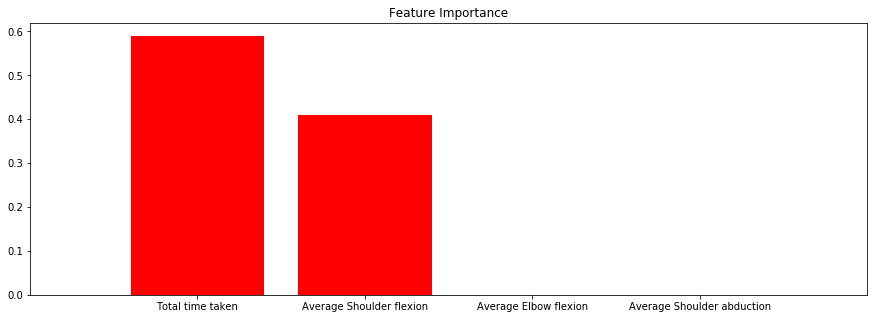

In [23]:
import scikitplot as skplt
skplt.estimators.plot_feature_importances(clf_decision_tree, feature_names=['Average Shoulder abduction', 'Average Shoulder flexion', 'Average Elbow flexion', 'Total time taken'], figsize=(15, 5))

Indeed, creating a decision tree on fewer features is the characteristic in which the algoirhtm specialises. This is fine for the training dataset. However, when applied in a real-world scenario to real patients, the client may find that it is in fact other features that are important in classifying patients, other than Average Shoulder flexion and Total Time Taken. Indeed, the cleint made this data only on an assumption of future patients' abilities. It is therefore necessary to choose a model that accepts more, rather than fewer, feature inputs, in order to be more robust. Conseqently, we visaluse the feature importance of the optimal random forest classifier, which also achieved 100% accuracy:

In [24]:
clf_random_forest = results['Random Forest'][1]

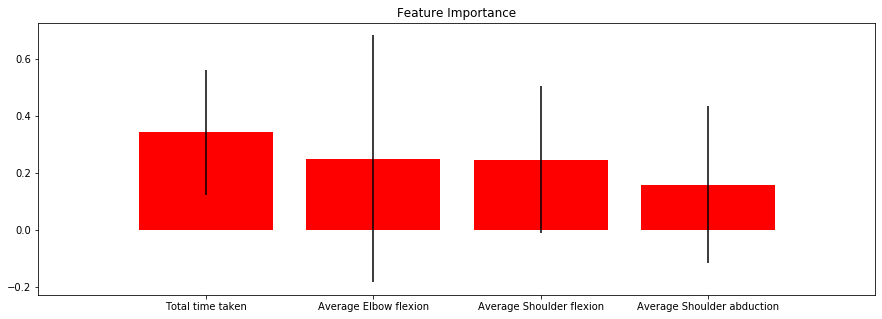

In [25]:
skplt.estimators.plot_feature_importances(clf_random_forest, feature_names=['Average Shoulder abduction', 'Average Shoulder flexion', 'Average Elbow flexion', 'Total time taken'], figsize=(15, 5))

Using all four features as inputs is more robust, and therefore becomes the classification model of choice. For the report, we export the decision tree into a visual format, illustrating what criteria the splitting algorithm chooses to separate the data into their corresponding classes, with the fewest number of splits.

In [26]:
from sklearn import tree
tree.export_graphviz(clf_decision_tree, out_file='tree.dot')   

In [27]:
from sklearn.externals.six import StringIO  
import pydot 
dot_data = StringIO() 
tree.export_graphviz(clf_decision_tree, out_file=dot_data) 
graph = pydot.graph_from_dot_data(dot_data.getvalue()) 
graph[0].write_pdf("graph.pdf")

C:\Users\samue\AppData\Roaming\Python\Python37\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


Since we have already obtained 100% accuracy on the training data, there is little need for a comparison between this and regression and ordinal regression, since we have already achieved optimal results (on the training data, it is always possible that we have overfit the data, which we will see in the testing data set accuracy scores). However, we will briefly compare classifcation, here, against regression and ordinal regression approaches, to see whether either of these approahces, for the algorithms on which we test, can also exhibit 100% accuracy.

## Regression

We start, therefore, with regression.

In [28]:
from sklearn import linear_model
reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [29]:
reg.coef_

array([ 0.02460376, -0.01245052,  0.04055719,  0.03369533])

In order to use accuracy scores, we need to convert the output of the regression model into an integer. Otherwise, the model will output a continuous number, which is not useful when we want a classification (Easy, Medium, or Hard). Consequently, we convert the outputs of the regression into integers, and run the accuracy scores these integer predictions.

In [30]:
from sklearn.metrics import accuracy_score
predictions = reg.predict(X_train)
predictions = np.around(predictions, decimals=0)
accuracy = accuracy_score(y_train, predictions)
accuracy

0.9666666666666667

This is alrady a very high accuracy score. In order to attempt to maximise it further (and reduce the extent of overfitting), we can apply Ridge Regression regularisation. We can combine this with Generalized Cross-Validation, which is a form of efficient Leave-One-Out cross-validation.

In [31]:
reg = linear_model.RidgeCV(alphas=np.logspace(-6, 6, 13))
reg.fit(X_train, y_train)

RidgeCV(alphas=array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01,
       1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06]),
        cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
        scoring=None, store_cv_values=False)

In [32]:
reg.alpha_

100.0

In [33]:
predictions = reg.predict(X_train)
predictions = np.around(predictions, decimals=0)
accuracy = accuracy_score(y_train, predictions)
accuracy

0.9666666666666667

As we can see, however, using regularisaion here does not increase the accuracy scores of the model. Rather than produce an accuracy score based on the entirity of the training data, it is more reliable to produces accuracy scores based on cross-validation.

In [34]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(reg, X_train, y_train, cv=5)
scores.mean()

0.8884203230244341

This score, however, is significantly lower than the above. This is because Scikit-learn's cross_val_score does not allow us to round the predicted values to the nearest integer before feeding into our accuaracy metric. In order to resolve this issue, we manually create a cross validation metric and run the regression again, complete with Ridge Regression regularisation:

In [35]:
from sklearn.model_selection import KFold
def reg():
    fold = KFold(n_splits = 5, shuffle = True)
    CV_score = []
    for i in range(4):
        split = next(fold.split(X_train), None)
        X_train_split, X_test_split, y_train_split, y_test_split = X_train.iloc[split[0]], X_train.iloc[split[1]], y_train.iloc[split[0]], y_train.iloc[split[1]]
        reg = linear_model.RidgeCV(alphas=np.logspace(-6, 6, 13))
        reg.fit(X_train_split, y_train_split)
        predictions = reg.predict(X_test_split)
        predictions = np.around(predictions, decimals=0)
        accuracy = accuracy_score(y_test_split, predictions)
        CV_score.append(accuracy)
    return np.mean(CV_score)

In [36]:
CV_score = reg()
CV_score

0.9000000000000001

As we can see, regression produces very strong results. It is not as strong as the best in the classification category, however, so in this notebook, we stick with classification as the most strongly performing model type.

## Ordinal Regression

Next we analyse ordinal regression.

In [37]:
import mord
log = mord.LogisticIT(alpha=1.0, verbose=0)
log.fit(X_train, y_train)
scores = cross_val_score(log, X_train, y_train, cv=5)
scores

array([1.        , 1.        , 1.        , 1.        , 0.91666667])

In [38]:
scores.mean()

0.9833333333333334

This is a very high accuracy score. It is lowered only by the 5th CV fold, which may be considered as an outlier. In order to attempt to maximise accuracy scores, we use Grid Search CV twice, in order to attempt to maximise the extent of regularisation, in order to reduce overfitting. To do this, we attempt to optimise the parameter alpha.

In [39]:
parameters_logIT = {'alpha': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}
CV = GridSearchCV(mord.LogisticIT(), parameters_logIT, cv=5, iid=False, scoring='accuracy', n_jobs=1)
CV = CV.fit(X_train, y_train)
print(f'Logistic IT scored {CV.best_score_}')
results = [CV.best_score_, CV.best_estimator_]
print(results)

Logistic IT scored 0.9833333333333334
[0.9833333333333334, LogisticIT(alpha=0.1, max_iter=1000, verbose=0)]


The value of alpha that maximised accuracy was 0.1, so we repeat Cross Validation, with updated values for the alpha hyperparameter.

In [40]:
parameters_logIT = {'alpha': [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.08, 0.1]}
CV = GridSearchCV(mord.LogisticIT(), parameters_logIT, cv=5, iid=False, scoring='accuracy', n_jobs=1)
CV = CV.fit(X_train, y_train)
print(f'Logistic IT scored {CV.best_score_}')
results = [CV.best_score_, CV.best_estimator_]
print(results)

Logistic IT scored 0.9833333333333334
[0.9833333333333334, LogisticIT(alpha=0.01, max_iter=1000, verbose=0)]


As we can see, however, such hyperparameter optimisation does not increase the accuracy scores further.

In [41]:
parameters_logAT = {'alpha': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}
CV = GridSearchCV(mord.LogisticAT(), parameters_logAT, cv=5, iid=False, scoring='accuracy', n_jobs=1)
CV = CV.fit(X_train, y_train)
print(f'Logistic AT scored {CV.best_score_}')
results = [CV.best_score_, CV.best_estimator_]
print(results)

Logistic AT scored 0.9833333333333334
[0.9833333333333334, LogisticAT(alpha=0.1, max_iter=1000, verbose=0)]


The All-Threshold and Immediate-Thershold variants have identical accuracy scores.

All of the models exhibit very similar results. Indeed, because of the small dataset, a single misclassification will bias the accuracy score downwards by almomst 2%. This means that most differences in the classification accuracies are due to only one or two misclassifications using cross-validation. Despite this, random forests performed best, and they will be used as the model of choice for the first table. They will now be tested for accuracy scores against the testing data.

## Model Scores

In [42]:
clf_random_forest

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=2, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=4,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [43]:
y_pred = clf_random_forest.predict(X_test)
y_pred

array([1, 1, 2, 1, 1, 3, 1, 2, 2, 2, 2, 3, 3, 3, 2], dtype=int64)

In [44]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

1.0

As can be seen, the model exhibits 100% accuracy on the testing data, which the highest we could want. This is a perfect model of choice, therefore. It need be stated, however, that random forests may not be the only perfect model of choice: there could exist several models that exhibit 100% accuracy scores on the testing data. However, because of the highest cross-validation score, combined with the most features chosen as input variables, random forests are chosen. Finally, a confusion matrix is plotted, and a reverse label encoder is applied, in order to view the lables as Easy, Medium, and Hard:

In [45]:
def reverse_label_encoder(y):
    if y == 1:
        return 'Easy'
    if y == 2:
        return 'Medium'
    if y == 3:
        return 'Hard'
y_pred_series = pd.Series(y_pred)
y_pred_original = y_pred_series.apply(reverse_label_encoder)
y_test_original = y_test.apply(reverse_label_encoder)

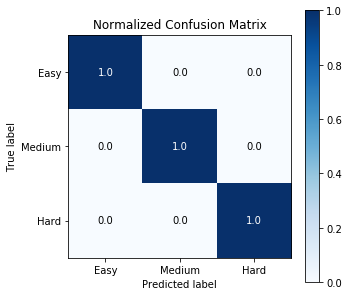

In [46]:
skplt.metrics.plot_confusion_matrix(y_test_original, y_pred_original, normalize=True, figsize=(5, 5), labels=['Easy', 'Medium', 'Hard'])
plt.autoscale()

As we can see, using a Random Forests classifier with optimal hyperparameters classifies every patient correctly. We now save the model, to import into other Python scripts and notebooks.

In [47]:
import joblib
joblib.dump(clf_random_forest, 'Table1_random_forest.pkl')

['Table1_random_forest.pkl']